# Some Exploratory Data Analysis: UCI Auto MPG Data Set
### Kevin Maher
### <span style="color:blue">Vettejeep365@gmail.com</span>

Imports needed for the script.  Uses Python 2.7.13, numpy 1.11.3, pandas 0.19.2, scipy 0.18.1, matplotlib 2.0.0.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

Set up a color pallette reputed to be color blind friendly.  From: https://gist.github.com/thriveth/8560036.  Yellow was left out because it plots poorly in the plots here.

In [4]:
colors = ('#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c')  # , '#dede00')

Read in the data.  I am using a modified version of the UCI Auto MPG data set.  Missing horsepower values have been looked up and a column to mark diesel vehicles added.  Data from: https://archive.ics.uci.edu/ml/datasets/Auto%2BMPG.

In [2]:
df = pd.read_csv('uci_auto_mpg_mod.csv')
print df.head()

    mpg  cylinders  displacement  horsepower  weight  acceleration  year  \
0  18.0          8         307.0         130    3504          12.0    70   
1  15.0          8         350.0         165    3693          11.5    70   
2  18.0          8         318.0         150    3436          11.0    70   
3  16.0          8         304.0         150    3433          12.0    70   
4  17.0          8         302.0         140    3449          10.5    70   

   origin                   car_name diesel  
0       1  chevrolet chevelle malibu     no  
1       1          buick skylark 320     no  
2       1         plymouth satellite     no  
3       1              amc rebel sst     no  
4       1                ford torino     no  


Lets check the effect of the number of cylinders a vehicle has vs. the fuel economy (mpg) by using a box plot.

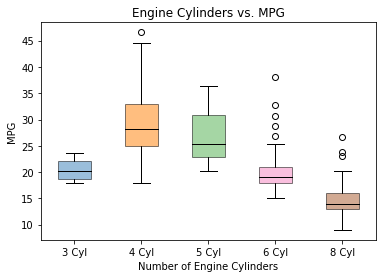

In [5]:
mpg3cyl = df['mpg'][df['cylinders'] == 3]
mpg4cyl = df['mpg'][df['cylinders'] == 4]
mpg5cyl = df['mpg'][df['cylinders'] == 5]
mpg6cyl = df['mpg'][df['cylinders'] == 6]
mpg8cyl = df['mpg'][df['cylinders'] == 8]

cyl = [mpg3cyl, mpg4cyl, mpg5cyl, mpg6cyl, mpg8cyl]

bplot = plt.boxplot(cyl,
                    notch=False,  # notch shape
                    vert=True,  # vertical box alignment
                    patch_artist=True,  # fill with color
                    labels=['3 Cyl', '4 Cyl', '5 Cyl', '6 Cyl', '8 Cyl'])  # will be used to label x-ticks
for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        patch._alpha = 0.5
for line in bplot['medians']:
    line._color = 'k'

plt.xlabel("Number of Engine Cylinders")
plt.ylabel("MPG")
plt.title("Engine Cylinders vs. MPG")
plt.show()

What is with 3 cylinder vehicles, why do they break the pattern of decreasing fuel economy with more cylinders?

In [6]:
df3cyl = df.loc[df['cylinders'] == 3]
print ' 3 cylinder cars'
print df3cyl['car_name']

 3 cylinder cars
71     mazda rx2 coupe
111          maxda rx3
243         mazda rx-4
334      mazda rx-7 gs
Name: car_name, dtype: object


3 cylinder cars are all Mazdas with rotary engines.  These actually have 3 chambers per rotor and 2 rotors per engine - so 3 x 2 = 6.  As plotted by the box plot they do indeed appear to share fuel economy charachteristics with 6 cylinder engines.  Possibly in a machine learning model it might be best to replace these by 6 cylinders, especially since there are so few of them.

Lets use a plot to check vehicle weight vs fuel economy (mpg) and add a regression line to the plot.

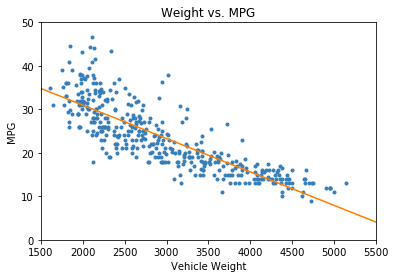

In [7]:
# fit the line
z = np.polyfit(df['weight'], df['mpg'], 1)
y_poly = [z[0] * x + z[1] for x in range(1500, 5600, 100)]
x_poly = [x for x in range(1500, 5600, 100)]

# plot
plt.plot(df['weight'], df['mpg'], ".", color=colors[0])
plt.plot(x_poly, y_poly, "-", color=colors[1])
plt.xlim(1500, 5500)
plt.ylim(0, 50)
plt.xlabel("Vehicle Weight")
plt.ylabel("MPG")
plt.title("Weight vs. MPG")
plt.show()
plt.close()

It appears that the relationship is not really linear.  So try a second order polynomial fit.

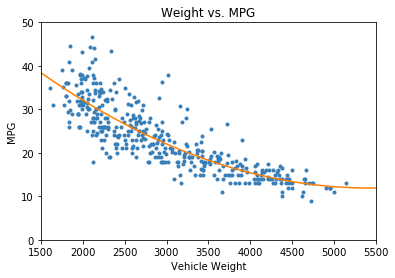

In [8]:
# second order fit
z = np.polyfit(df['weight'], df['mpg'], 2)
y_poly2 = [z[0] * x ** 2 + z[1] * x + z[2] for x in range(1500, 5600, 100)]

# plot it
plt.plot(df['weight'], df['mpg'], ".", color=colors[0])
plt.plot(x_poly, y_poly2, "-", color=colors[1])
plt.xlim(1500, 5500)
plt.ylim(0, 50)
plt.xlabel("Vehicle Weight")
plt.ylabel("MPG")
plt.title("Weight vs. MPG")
plt.show()
plt.close()

The second order polynomial does appear to fit better than the first order (straight line).  Hence, a machine learning model should either try to capture the higher order effect with squared terms or use a machine learning method that copes well with non-linearity such as Random Forests or other similar tree-based algorithms. 

Here is a more complex scatter plot showing the results for weight vs. mpg broken out by the number of cylinders in the engine.

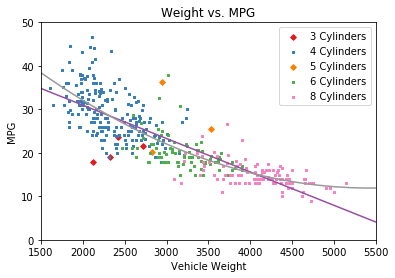

In [9]:
markers = ('s', 'D')
cyls = pd.unique(df.cylinders.values)
cyls = np.sort(cyls)

for i, cyl in enumerate(cyls):
    if cyl ==3 or cyl == 5:
        s = 16
        m = markers[1]
    else:
        s = 4
        m = markers[0]

    plt.scatter(df['weight'].loc[df['cylinders'] == cyl],
                df['mpg'].loc[df['cylinders'] == cyl],
                s=s, c=colors[i-1], marker=m, label='%d Cylinders' % cyl)

plt.plot(x_poly, y_poly, "-", color=colors[5])
plt.plot(x_poly, y_poly2, "-", color=colors[6])
plt.xlim(1500, 5500)
plt.ylim(0, 50)
plt.xlabel("Vehicle Weight")
plt.ylabel("MPG")
plt.title("Weight vs. MPG")
plt.legend()
plt.show()
plt.close()

Looking at this last plot, perhaps the rotary engines need to be in their own category since they get 6 cylinder mileage but the cars are generally lighter than 6 cylinder vehicles.  Also, in the plot above we can observe clusters that more cylinders generally lead to increasing weight and lower mpg.  Multi-collinearity could be a problem in this data set, here the relationship between weight and cylinders.

A look at displacement vs. horsepower, another source of possible multi-collinearity in the data since there is a generally linear relationship.

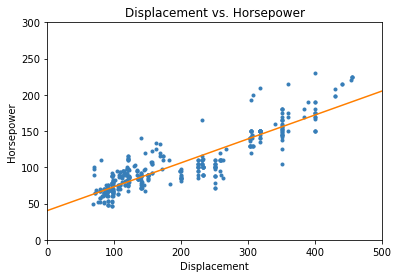

In [10]:
z = np.polyfit(df['displacement'], df['horsepower'], 1)
y_poly = [z[0] * x + z[1] for x in range(0, 600, 50)]
x_poly = [x for x in range(0, 600, 50)]

plt.plot(df['displacement'], df['horsepower'], '.', color=colors[0])
plt.plot(x_poly, y_poly, '-', color=colors[1])
plt.xlim(0, 500)
plt.ylim(0, 300)
plt.xlabel("Displacement")
plt.ylabel("Horsepower")
plt.title("Displacement vs. Horsepower")
plt.show()
plt.close()

Mean mpg by the region of origin of a vehicle.  The origin code is translated to a more human readable format.  Origin is either related to fuel economy or lighter vehicles come from Japan and Europe than from the US in this time period (1970's to 1980's).

In [11]:
df['origin_name'] = df['origin'] - 1
df['origin_name'] = df['origin_name'].astype('category')
df['origin_name'] = pd.Series(pd.Categorical.from_codes(df['origin_name'], categories=['US', 'EUR', 'JPN']))
mean_mpg = df.groupby('origin_name', as_index=False)['mpg'].mean()
print 'Mean value of mpg, by vehicle origin:'
print mean_mpg.to_string(index=False)

Mean value of mpg, by vehicle origin:
origin_name        mpg
        US  20.083534
       EUR  27.891429
       JPN  30.450633


Can we verify statistically what the box plot apears to show - that cylinders is significant as a predictor of fuel economy?  I will work with only the 4, 6 and 8 cylinder cars here since 3 and 5 cylinder cars are rare.

Set up data frame for 4, 6 and 8 cylinder vehicles.

In [12]:
df468 = df.loc[df.cylinders != 3]
df468 = df468.loc[df468.cylinders != 5]

Check for normal distributions of the data - the test fails - note the p-values far below the normal level of significance of 0.05.  All three cylinder types fail the nnormality test.

In [13]:
s, p = stats.normaltest(df468['mpg'].loc[df468['cylinders'] == 4])
print 'Normality test for mpg with 4 cylinders, p-value: %.4f' % p
s, p = stats.normaltest(df468['mpg'].loc[df468['cylinders'] == 6])
print 'Normality test for mpg with 6 cylinders, p-value: %.4f' % p
s, p = stats.normaltest(df468['mpg'].loc[df468['cylinders'] == 8])
print 'Normality test for mpg with 8 cylinders, p-value: %.4f' % p

Normality test for mpg with 4 cylinders, p-value: 0.0096
Normality test for mpg with 6 cylinders, p-value: 0.0000
Normality test for mpg with 8 cylinders, p-value: 0.0000


Histograms show skewed distributions.

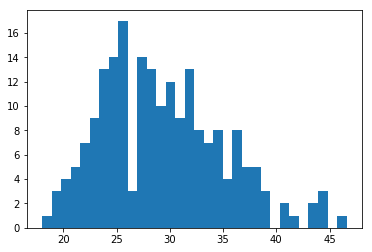

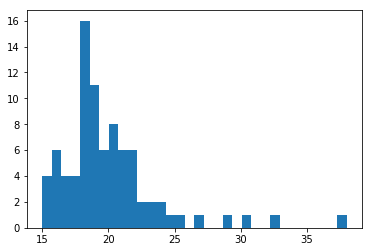

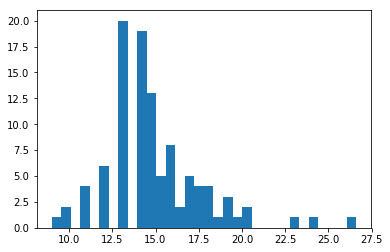

In [14]:
plt.hist(df468['mpg'].loc[df468['cylinders'] == 4], bins=32)
plt.show()
plt.close()

plt.hist(df468['mpg'].loc[df468['cylinders'] == 6], bins=32)
plt.show()
plt.close()

plt.hist(df468['mpg'].loc[df468['cylinders'] == 8], bins=32)
plt.show()
plt.close()

Even with non-normal data Levene's test can be used to check for equal variances.  This test also fails for the 4 cylinder vehicles against 6 and 8 cylinder vehicles, so we cannot assumeequal variances going forward.

In [15]:
W, p = stats.levene(df468['mpg'].loc[df468['cylinders'] == 4], df468['mpg'].loc[df468['cylinders'] == 6])
print 'Levene test for equal variances, 4 vs 6 cylinder vehicles, p-value: %.4f' % p
W, p = stats.levene(df468['mpg'].loc[df468['cylinders'] == 4], df468['mpg'].loc[df468['cylinders'] == 8])
print 'Levene test for equal variances, 4 vs 8 cylinder vehicles, p-value: %.4f' % p
W, p = stats.levene(df468['mpg'].loc[df468['cylinders'] == 6], df468['mpg'].loc[df468['cylinders'] == 8])
print 'Levene test for equal variances, 6 vs 8 cylinder vehicles, p-value: %.4f' % p

Levene test for equal variances, 4 vs 6 cylinder vehicles, p-value: 0.0000
Levene test for equal variances, 4 vs 8 cylinder vehicles, p-value: 0.0000
Levene test for equal variances, 6 vs 8 cylinder vehicles, p-value: 0.2674


The Kruskal ANOVA test can be used when conditions of normality and equal variances are not satisfied.  As expected, the p-value is almost zero, so the loss of power in the test from not having normality and equal variances should not be important here.  Cylinders may well prove to be a good predictive variable for mpg, though we may need to consider multi-collinearity with other variables such as weight and displacement.

In [17]:
grps = pd.unique(df468.cylinders.values)
d_data = {grp: df468['weight'][df468.cylinders == grp] for grp in grps}
kruskal = stats.kruskal(d_data[4], d_data[6], d_data[8])
print 'kruskal'
print kruskal

kruskal
KruskalResult(statistic=302.12652510002124, pvalue=2.4777566832235739e-66)


In conclusion for this partial EDA on the UCI Auto MPG Data Set, a machine learning model may need to deal with several issues.  These are the non-linearities in some of the data and potential issues of multi-collinearity.

Citation:
Auto MPG Data Set (1993). UCI Machine Learning Repository.  Retrieved from: https://archive.ics.uci.edu/ml/datasets/Auto%2BMPG. 